<a href="https://colab.research.google.com/github/TurkuNLP/textual-data-analysis-course/blob/main/sequence_labeling_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence labeling example

Let's train a transformer model on a Named Entity Recognition (NER) dataset.

---

## Setup

Install the required Python packages:

In [1]:
!pip install --quiet transformers datasets evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Import the libraries we'll be using here.

In [2]:
import datasets
import transformers
import evaluate

from pprint import pprint

Make things a bit more quiet. (This only affects what shows on screen when running. If you're debugging, you probably want to comment these out.)

In [3]:
transformers.utils.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()
datasets.disable_progress_bar()

---

## Load dataset

Load a dataset for training using `datasets`.

In [4]:
DATASET = 'conll2003'

builder = datasets.load_dataset_builder(DATASET)
dataset = datasets.load_dataset(DATASET)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Let's have a look at the description and dataset.

In [5]:
print(builder.info.description)

The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on
four types of named entities: persons, locations, organizations and names of miscellaneous entities that do
not belong to the previous three groups.

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on
a separate line and there is an empty line after each sentence. The first item on each line is a word, the second
a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags
and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only
if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag
B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Note the dataset uses IOB2
tagging scheme, whereas the original dataset uses IOB1.

For 

In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


We have the conventional split into `train`, `validation`, and `test`.

We're here only interested in the `tokens` and `ner_tags`. (In particular, the `ner_tags` and `chunk_tags` are included to support methods based on manually engineered features, and as such not highly relevant to the deep learning approach we're pursuing here.)

Let's have a look at one example.

In [7]:
print(dataset['train'][0]['tokens'])
print(dataset['train'][0]['ner_tags'])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


Take note of the number of different labels and create mappings from label IDs to label strings and vice versa; we'll need these later.

In [8]:
label_names = dataset['train'].features['ner_tags'].feature.names
print('Labels:', label_names)

num_labels = len(label_names)
id2label = { k: v for k, v in enumerate(label_names) }
label2id = { v: k for k, v in enumerate(label_names) }

print('Number of labels:', num_labels)
print('id2label mapping:', id2label)
print('labelid2 mapping:', label2id)

Labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
Number of labels: 9
id2label mapping: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
labelid2 mapping: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


Let's see that example again, applying the label mapping:

In [9]:
for token, tag_id in zip(dataset['train'][0]['tokens'], dataset['train'][0]['ner_tags']):
    print(f'{token}\t{id2label[tag_id]}')

EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
lamb	O
.	O


---

## Tokenize and vectorize dataset

As in the [text classification notebook](https://github.com/TurkuNLP/textual-data-analysis-course/blob/main/text_classification_basic_example.ipynb), we'll first load the tokenizer that corresponds to the model that we want to use. `AutoTokenizer` is a convenience class that will return the appropriate tokenizer for the model it's given as an argument:

In [10]:
MODEL = 'bert-base-cased'

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

The tokenizer will, most importantly, produce `input_ids`, which identify the tokens of the text.

The BERT tokenizer also produces an `attention_mask`, which can be used to make the model ignore some tokens, and `token_type_ids`, which can differentiate parts of the input e.g. when it consists of two separate texts.

In [11]:
pprint(tokenizer('this is an example sentence'))

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101, 1142, 1110, 1126, 1859, 5650, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


A key point here is to note that the data already has its own definition of "token", and the tokenizer may split some of those into parts:

In [12]:
input_ids = tokenizer('Turku is not in the vocabulary').input_ids


print(input_ids)
print()
print(tokenizer.convert_ids_to_tokens(input_ids))

[101, 17037, 4661, 1358, 1110, 1136, 1107, 1103, 18074, 102]

['[CLS]', 'Tu', '##rk', '##u', 'is', 'not', 'in', 'the', 'vocabulary', '[SEP]']


For each sentence, our data consists of a tokenized list of strings ("words") rather than a single string. If we call the tokenizer with its default options, it interprets each token as a different example:

In [13]:
print(dataset['train'][0]['tokens'])
print()

for ids in tokenizer(dataset['train'][0]['tokens']).input_ids:
    print(tokenizer.convert_ids_to_tokens(ids))

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

['[CLS]', 'EU', '[SEP]']
['[CLS]', 'rejects', '[SEP]']
['[CLS]', 'German', '[SEP]']
['[CLS]', 'call', '[SEP]']
['[CLS]', 'to', '[SEP]']
['[CLS]', 'boycott', '[SEP]']
['[CLS]', 'British', '[SEP]']
['[CLS]', 'la', '##mb', '[SEP]']
['[CLS]', '.', '[SEP]']


To get the correct mapping, we provide `is_split_into_words=True` to the tokenizer.

In [14]:
tokens = 'Turku is not in the vocabulary'.split()
tokenized = tokenizer(tokens, is_split_into_words=True)

print(tokens)
print()
pprint(tokenizer.convert_ids_to_tokens(tokenized.input_ids))

['Turku', 'is', 'not', 'in', 'the', 'vocabulary']

['[CLS]', 'Tu', '##rk', '##u', 'is', 'not', 'in', 'the', 'vocabulary', '[SEP]']


The tokenizer also provides us with a mapping from the tokenizer tokens to "original" tokens ("words")

In [15]:
tokenized.word_ids()

[None, 0, 0, 0, 1, 2, 3, 4, 5, None]

With `is_split_into_words=True`, we can tokenize the input so that its tokens are compatible with the model, but the labels will be misaligned.

In [16]:
from itertools import zip_longest

token_ids = tokenizer(dataset['train'][0]['tokens'], is_split_into_words=True).input_ids
tag_ids = dataset['train'][0]['ner_tags']

for token_id, tag_id in zip_longest(token_ids, tag_ids):
    token = tokenizer.convert_ids_to_tokens(token_id)
    tag = id2label[tag_id] if tag_id is not None else None
    print(f'{token}\t{tag}')

[CLS]	B-ORG
EU	O
rejects	B-MISC
German	O
call	O
to	O
boycott	B-MISC
British	O
la	O
##mb	None
.	None
[SEP]	None


To resolve this, we'll borrow a function from [a transformers tutorial](https://huggingface.co/course/chapter7/2). Here, `-100` is a "magic value" for a label that pytorch ignores.

In [17]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:    # Start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:          # Special token
            new_labels.append(-100)
        else:                          # Same word as previous token
            label = labels[word_id]
            if label % 2 == 1:         # If label is B-XXX we change it to I-XXX
                label += 1
            new_labels.append(label)
    return new_labels

We'll also borrow a function for jointly tokenizing the text and aliging labels:

In [18]:
def tokenize_and_align_labels(inputs):
    outputs = tokenizer(inputs['tokens'], truncation=True, is_split_into_words=True)
    new_labels = []
    for i, labels in enumerate(inputs['ner_tags']):
        word_ids = outputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    outputs['labels'] = new_labels
    return outputs

We'll then apply this to the whole dataset:

In [19]:
dataset = dataset.map(tokenize_and_align_labels, batched=True)

Now these should match up:

In [20]:
token_ids = dataset['train'][0]['input_ids']
tag_ids = dataset['train'][0]['labels']

for token_id, tag_id in zip_longest(token_ids, tag_ids):
    token = tokenizer.convert_ids_to_tokens(token_id)
    tag = id2label[tag_id] if tag_id != -100 else None
    print(f'{token}\t{tag}')

[CLS]	None
EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
la	O
##mb	O
.	O
[SEP]	None


---

## Instantiate model

Now, we'll instantiate a pretrained model with a sequence labeling head. In the `transformers` library, this class of models are named `...ModelForTokenClassification`. (cf. `...ModelForSequenceClassification`) We'll again use the `Auto` variant to get the appropriate class based on model name.

**NOTE**: we need to provide the number of labels to `from_pretrained` so that the function knows the size of the output layer that is required. The `id2label` and `label2id` mappings allow the model to report its classification results in interpretable text labels.

In [21]:
model = transformers.AutoModelForTokenClassification.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

---

## Training configuration

To assess the progress and results of training, we'll use the standard `seqeval` library. We'll also need to introduce a function that takes model outputs and the labels from the dataset and calls the metric.

Here, we'll again borrow from [the transformers tutorial](https://huggingface.co/course/chapter7/2):

In [22]:
metrics = evaluate.load('seqeval')


def compute_metrics(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[i] for i in label if i != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metrics.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': all_metrics['overall_precision'],
        'recall': all_metrics['overall_recall'],
        'f1': all_metrics['overall_f1'],
        'accuracy': all_metrics['overall_accuracy'],
    }

We'll also need a collator for padding the examples to the same length to process them in batches.

In [23]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

The `TrainingArguments` class configures many of the details of the model training. You may want to try optimizing the following hyperparameters to improve model performance:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per training batch
* `max_steps`: the maximum number of steps to train for

In [32]:
trainer_args = transformers.TrainingArguments(
    report_to="none",
    output_dir='checkpoints',
    evaluation_strategy='steps',
    logging_strategy='steps',
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    max_steps=1500,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Finally, we'll create a custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [33]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

---

## Train (fine-tune) model

In [34]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[training_logs],
)

<ipython-input-34-b69a91af59e1>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Trainer(


In [35]:
trainer.train()

{'loss': 0.5848, 'grad_norm': 1.4654312133789062, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.11389521640091116}
{'eval_loss': 0.20780247449874878, 'eval_precision': 0.6575408261287223, 'eval_recall': 0.6911814203971727, 'eval_f1': 0.6739415818838201, 'eval_accuracy': 0.938143874727733, 'eval_runtime': 10.4708, 'eval_samples_per_second': 310.388, 'eval_steps_per_second': 9.741, 'epoch': 0.11389521640091116}
{'loss': 0.1761, 'grad_norm': 3.714163303375244, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.22779043280182232}
{'eval_loss': 0.12966963648796082, 'eval_precision': 0.7746542393265183, 'eval_recall': 0.8672164254459778, 'eval_f1': 0.8183261870732095, 'eval_accuracy': 0.9614999705657268, 'eval_runtime': 9.3559, 'eval_samples_per_second': 347.375, 'eval_steps_per_second': 10.902, 'epoch': 0.22779043280182232}
{'loss': 0.1502, 'grad_norm': 4.005847454071045, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.3416856492027335}
{'eval_loss': 0.09889386594295502, 'eval_pre

TrainOutput(global_step=1500, training_loss=0.11440034103393555, metrics={'train_runtime': 406.8455, 'train_samples_per_second': 58.99, 'train_steps_per_second': 3.687, 'train_loss': 0.11440034103393555, 'epoch': 1.7084282460136673})

---

## Evaluate trained model

We can use the `trainer` to evaluate the trained model using the metric we defined:

In [36]:
eval_results = trainer.evaluate(dataset['test'])

pprint(eval_results)

print('\nF1:', eval_results['eval_f1'])

{'eval_loss': 0.15227897465229034, 'eval_precision': 0.8675373134328358, 'eval_recall': 0.9056303116147308, 'eval_f1': 0.8861746361746361, 'eval_accuracy': 0.9697924709664203, 'eval_runtime': 12.5298, 'eval_samples_per_second': 275.584, 'eval_steps_per_second': 8.619, 'epoch': 1.7084282460136673}
{'epoch': 1.7084282460136673,
 'eval_accuracy': 0.9697924709664203,
 'eval_f1': 0.8861746361746361,
 'eval_loss': 0.15227897465229034,
 'eval_precision': 0.8675373134328358,
 'eval_recall': 0.9056303116147308,
 'eval_runtime': 12.5298,
 'eval_samples_per_second': 275.584,
 'eval_steps_per_second': 8.619}

F1: 0.8861746361746361


As we captured performance during training using the `training_logs` callback, we can also have a look at training and evaluation loss and evaluation $F_1$ progression. (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

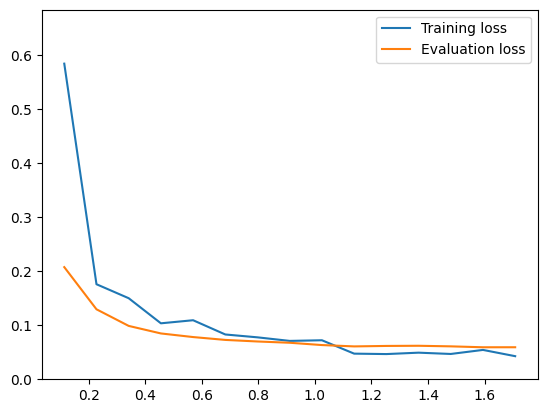

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):
        plt.plot(logs['epoch'], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ['loss', 'eval_loss'], ['Training loss', 'Evaluation loss'])

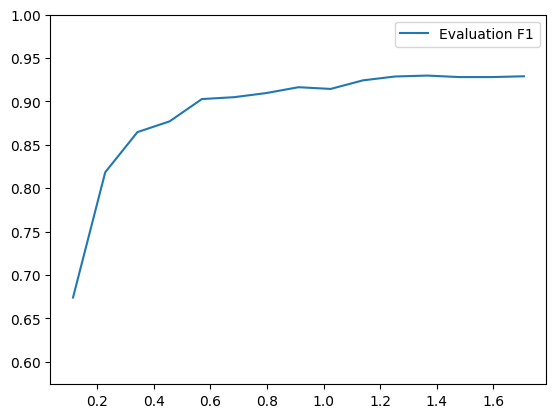

In [38]:
plot(training_logs.logs, ['eval_f1'], ['Evaluation F1'])

---

## Create pipeline



We can wrap our fine-tuned model in a pipeline for convenience. (We need to specify `device` here as the model is on GPU.)

In [39]:
pipe = transformers.pipeline(
    'token-classification',
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy='simple',
    device=0
)

We can then use the pipeline simply as follows:

In [40]:
pipe('Finnish cities include Turku and Tampere.')

[{'entity_group': 'MISC',
  'score': 0.99383944,
  'word': 'Finnish',
  'start': 0,
  'end': 7},
 {'entity_group': 'LOC',
  'score': 0.9963088,
  'word': 'Turku',
  'start': 23,
  'end': 28},
 {'entity_group': 'LOC',
  'score': 0.9957153,
  'word': 'Tampere',
  'start': 33,
  'end': 40}]

Or, for convenience

In [41]:
def tag(text):
    output = pipe(text)
    print('input:', text)
    print('output:', [(o['word'], o['entity_group']) for o in output])

tag('Finnish cities include Turku and Tampere.')

input: Finnish cities include Turku and Tampere.
output: [('Finnish', 'MISC'), ('Turku', 'LOC'), ('Tampere', 'LOC')]


In [42]:
tag('Paavo Nurmi was born in Turku in 1897.')

input: Paavo Nurmi was born in Turku in 1897.
output: [('Paavo Nurmi', 'PER'), ('Turku', 'LOC')]


In [43]:
tag('Nokia is a company founded near the town of Nokia.')

input: Nokia is a company founded near the town of Nokia.
output: [('Nokia', 'ORG'), ('Nokia', 'LOC')]
